In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np

from utils import *


sys.path.insert(0, str(Path("exact_solver")))
from exact_solver.runner import *

### Instancias

In [2]:

instances = [Instance("instance_4th5th_2025sem2"), Instance("instance_4th5th_2026sem1"), Instance("instance_2025sem2"), Instance("instance_2026sem1")]
experiments = []
objectives = ["except_timeslots", "elective_overlap", "prof_days", "preference"]

In [3]:
df_stats = display_stats_table(instances)
df_stats
# latex_code = df_stats.to_latex(index=False, float_format="%.2f")
# print(latex_code)

,instancia,#grupos,#cursos,#electivas,#profesores,#solicitudes_min_dias,#carga_horaria_por_grupo,#salones,%disponibilidad
0,instance_4th5th_2025sem2,9,34,20,29,34%,34.67,8,35%
1,instance_4th5th_2026sem1,9,56,10,55,25%,32.22,8,45%
2,instance_2025sem2,27,127,20,95,29%,28.89,13,38%
3,instance_2026sem1,29,165,10,117,30%,27.52,13,43%


### Método lexicográfico

In [4]:
instance = instances[1]

method = "lexicographic"
folder = f"results\\{instance.name}\\{method}"


for file in os.listdir(folder):
    filepath = os.path.join(folder, file)
    experiment = Experiment(instance, filepath)
    experiments.append(experiment)


In [5]:
df = display_experiments([e for e in experiments if e.instance == instance])
df

,exec_time (s),value except_timeslots,value elective_overlap,value prof_days,value preference
0,20.52,8.0,30.0,23.0,326.0
1,16.00,8.0,30.0,26.0,321.0
2,30.37,8.0,38.0,23.0,316.0
3,14.25,26.0,34.0,24.0,295.0
4,22.48,18.0,12.0,23.0,325.0
5,9.92,34.0,12.0,24.0,301.0
6,18.63,18.0,12.0,23.0,325.0
7,14.00,36.0,18.0,24.0,295.0
8,32.75,22.0,42.0,23.0,297.0
9,11.08,24.0,42.0,24.0,295.0


### Matriz de pagos

In [6]:
display_experiments([e for e in experiments if e.instance == instance and e.method == "lexicographic"
                          and e.priorities in [
                              [0, 1, 2, 3], 
                              [1, 2, 3, 0], 
                              [2, 3, 0, 1], 
                              [3, 0, 1, 2], 
                              ]])[[
                                  "value except_timeslots", "value elective_overlap", "value prof_days", "value preference"
                                  ]]

,value except_timeslots,value elective_overlap,value prof_days,value preference
0,8.0,30.0,23.0,326.0
1,22.0,42.0,23.0,297.0
2,34.0,12.0,23.0,304.0
3,26.0,34.0,24.0,295.0


### Parámetros para AUGMECON2

In [7]:
df2 = display_objectives_ranges(df, objectives)
df2
# latex_code = df2.to_latex(index=False, float_format="%.0f")
# print(latex_code)

,objective,max,min,range
0,except_timeslots,36.0,8.0,28.0
1,elective_overlap,42.0,12.0,30.0
2,prof_days,26.0,23.0,3.0
3,preference,326.0,295.0,31.0


In [8]:
ranges = df2.set_index("objective")["range"].to_dict()
mins = df2.set_index("objective")["min"].to_dict()
maxs = df2.set_index("objective")["max"].to_dict()

nadir = np.array(list(maxs.values()))
print("Vector nadir:", nadir)
ideal = np.array(list(mins.values()))
print("Vector ideal:", ideal)

Vector nadir: [ 36.  42.  26. 326.]
Vector ideal: [  8.  12.  23. 295.]


#### Definir intervalos/pasos

In [9]:

obj1 = "preference"
steps = {}

for o in objectives:
    if o != obj1:
        m, M, r = mins[o], maxs[o], ranges[o]
        num_steps = 9+1 if o != "prof_days" else 3+1  # cantidad de pasos
        step_size = r/(num_steps-1) if r > 0 else 1

        steps[o] = []
        for i in range(num_steps):
            st = max(M - i*step_size, m)
            steps[o].append(int(st))

print(*steps.items(), sep="\n")



('except_timeslots', [36, 32, 29, 26, 23, 20, 17, 14, 11, 8])
('elective_overlap', [42, 38, 35, 32, 28, 25, 22, 18, 15, 12])
('prof_days', [26, 25, 24, 23])


#### Comandos para ejecutar iteraciones

In [10]:
# prev_solution = None

# base_cmd = [
#             "python", "exact_solver/runner.py",
#             "--instance", instance.name, "--method", "augmecon",
#             "--priorities", "0 1 2 3", "--ranges", " ".join(str(int(v)) for v in ranges.values()),            
#         ]

# for st2 in steps["prof_days"]:
#     for st1 in steps["elective_overlap"]:
#         for st0 in steps["except_timeslots"]:
                   
#             bounds_cmd = ["--upper_bounds", f"{st0} {st1} {st2} None"]
#             file = f"sol_preference_{st2}_{st1}_{st0}.json"
            
#             if file not in os.listdir(f"results\\{instance.name}\\augmecon"):
#                 print(" ".join(base_cmd + bounds_cmd))
#             # else:
#             #     print(" ")
        
#     #     print('\n')
#     # print('\n\n')




### AUGMECON2: resultados

In [11]:
instance = instances[1]
folder = f"results\\{instance.name}\\augmecon"


for file in os.listdir(folder):
    filepath = os.path.join(folder, file)
    experiment = Experiment(instance, filepath)
    experiments.append(experiment)


In [12]:
df = display_experiments([e for e in experiments if e.instance == instance and e.method == "augmecon"])
all_points = df[["value except_timeslots", "value elective_overlap", "value prof_days", "value preference"]].to_numpy()
df


,exec_time (s),value preference,value prof_days,value elective_overlap,value except_timeslots
0,18.43,318.0,23.0,12.0,20.0
1,9.86,312.0,23.0,12.0,22.0
2,11.76,308.0,23.0,12.0,26.0
3,15.13,307.0,23.0,12.0,28.0
4,16.46,305.0,23.0,12.0,32.0
...,...,...,...,...,...
339,3.25,295.0,25.0,42.0,26.0
340,3.11,295.0,24.0,34.0,28.0
341,4.15,295.0,24.0,34.0,32.0
342,2.11,295.0,24.0,20.0,36.0


#### Cubrimiento del método

In [13]:
display_objectives_ranges(df, objectives)[["objective", "min", "max"]]

,objective,min,max
0,except_timeslots,8.0,36.0
1,elective_overlap,12.0,42.0
2,prof_days,23.0,26.0
3,preference,295.0,325.0


In [14]:
print("Tiempo total:", np.sum(df["exec_time (s)"]))

Tiempo total: 5601.79


Filtrar soluciones no dominadas

In [15]:
lex_points = display_experiments([e for e in experiments if e.instance == instance
                                  and e.method == "lexicographic"])[
                                      ["value except_timeslots", "value elective_overlap", "value prof_days", "value preference"]
                                      ].to_numpy()

no_dom_points = filtrar_no_dominados(lex_points)

print(f"Tasa de error soluciones no dominadas: {(1-len(no_dom_points)/len(lex_points)):.2%} ({len(lex_points)-len(no_dom_points)}/{len(lex_points)})")

Tasa de error soluciones no dominadas: 0.00% (0/24)


In [16]:
no_dom_points = filtrar_no_dominados(all_points)

print(f"Tasa de error soluciones no dominadas: {(1-len(no_dom_points)/len(all_points)):.2%} ({len(no_dom_points)}/{len(all_points)})")

Tasa de error soluciones no dominadas: 15.70% (290/344)


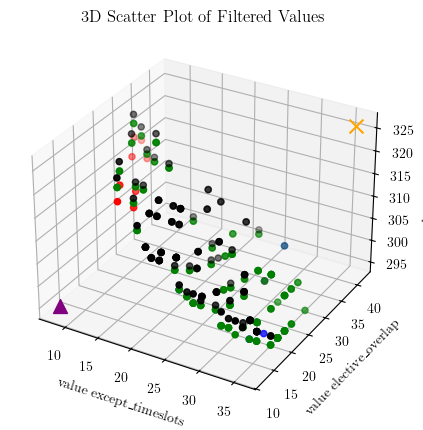

In [17]:
plot3d(df, steps, objectives, ideal, nadir)
plt.show()


#### Cálculo de hipervolumen

In [18]:
from pymoo.indicators.hv import HV

# Calcular hipervolumen
hv = HV(ref_point=nadir)
hv_lex = hv(filtrar_no_dominados(lex_points))
hv_ac = hv(filtrar_no_dominados(all_points))

print("Hipervolumen relativo", hv_ac/hv_lex)


Hipervolumen relativo 3.660933660933661


### Análisis bi objetivo

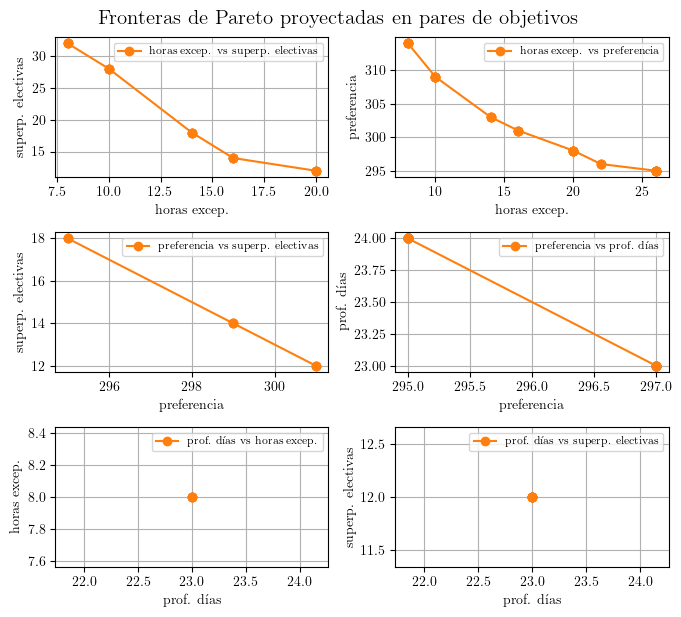

In [20]:

pairs = [
    [0, 1], [0, 3],
    [3, 1], [3, 2],
    [2, 0], [2, 1],
]

fig, axes = plt.subplots(3, 2, figsize=(7, 6))

for ax, pair in zip(axes.flat, pairs):
    plot_two_objectives(pair, all_points, ax, ["horas excep.", "superp. electivas", "prof. días", "preferencia"])

plt.tight_layout()
plt.suptitle("Fronteras de Pareto proyectadas en pares de objetivos", fontsize=15, y=1.02)
# plt.savefig("informe/pareto_fronts.png", dpi=500, bbox_inches="tight")
plt.show()
